In [1]:
from fastai.text import *
import html

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import csv

PATH = Path('pretrained/')
DATA_PATH = Path('data/')
MODEL_PATH = Path('models/')
LM_PATH = Path('lm/')
LM_PATH.mkdir(exist_ok=True)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [7]:
%%time
# import nltk
import pickle
import re
import numpy as np
import html

# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopwords_set = set(stopwords.words('english'))


re1 = re.compile(r'  +')
def clean_text(x, remove_html=True, other=True):
    if remove_html:
        x = re.sub(r'<code>[^>]*</code>', '', x)
        x = re.sub(r'<[^>]*>', '', x)
        x = re.sub(r'(.*\/).*', '', x)
    if other:
        x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '').replace('<unk>','u_n').replace(' @.@ ','.').replace(
            ' @-@ ','-').replace('\\', ' \\ ').replace('"',"'").replace('(', ' ( ').replace('[', '[ ').replace(
            '->', ' -> ').replace('<', '').replace('>', '').strip()
    return re1.sub(' ', html.unescape(x).strip())




re1 = re.compile(r'  +')
def clean_title(text, remove_html=False, other=False):
    
    replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
    bad_symbols_re = re.compile('[^0-9a-z #+_]')
    
    if remove_html:
        x = re.sub(r'<code>[^>]*</code>', '', x)
        x = re.sub(r'<[^>]*>', '', x)
        x = re.sub(r'[^A-Za-z0-9]', ' ', x)
    text = text.lower()
    text = text.replace('π', 'pi').replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '').replace('<unk>','u_n').replace(' @.@ ','.').replace(
            ' @-@ ','-').replace('\\', ' \\ ').replace('"',"'").replace('\n', ' ').replace('\r', ' ')
    text = replace_by_space_re.sub(' ', text)
    text = bad_symbols_re.sub('', text)
    text = ' '.join([x for x in text.split() if x and x not in stopwords_set])
    return re1.sub(' ', html.unescape(text).strip())


import sqlite3
DB_NAME = 'StackOverflow_python.db'

connection = sqlite3.connect(DB_NAME)
c = connection.cursor() 

def get_data(column):
#     df = pd.read_sql("SELECT {} FROM posts WHERE parent_id is NULL".format(column), 
#                  connection, chunksize=10000)
    df = pd.read_sql("SELECT {} FROM posts WHERE parent_id is NOT NULL".format(column), 
                 connection, chunksize=10000)
    all_text = preprocess(df)
    return all_text
    

def find_parent(pid):
    try:
        sql = "SELECT comment FROM posts WHERE comment_id = '{}' LIMIT 1".format(pid)
        c.execute(sql)
        result = c.fetchone()
        if result != None: return result[0]
        else: return False
    except Exception as e:
#         print(str(e))
        return False


def find_parent_pandas(pids):
        print(pids)
        neighbor_length = '?,' * len(pids)
        df = pd.read_sql("SELECT title FROM posts WHERE comment_id IN ({})".format(neighbor_length[:-1]), 
                                         connection, params=tuple(pids))
        return df
    
def accectable(row):
    if not 'code' in row:
        return row
        
        

    
    
    
def preprocess(df):
#     final_df = pd.DataFrame(columns=['comment_id', 'title', 'comment'])
#     final_df = pd.DataFrame(columns=['comment', 'parent_id', 'score', 'title'])
    final_df = pd.DataFrame(columns=['title', 'comment', 'score'])
    for i, data in enumerate(df):
#         data['title'] = data['title'].map(lambda x: clean_title(x))
#         data['comment'] = data['comment'].map(lambda x: accectable(x))
        # drop columns that have 'code' in them
#         data = data.replace(to_replace='None', value=np.nan).dropna()
        data['comment'] = data['comment'].map(lambda x: clean_text(x))

        data['title'] = data['parent_id'].map(lambda x: find_parent(x))
        data['title'] = data['title'].map(lambda x: clean_text(x))
        # keep only highest scoring comment 
        data = data.groupby('parent_id', as_index=False).max()
        final_df = final_df.append(data[['title', 'comment', 'score']])
    return final_df

# df = get_data('comment_id, title, comment')
df = get_data('comment, parent_id, score')
df = df[df.score > 0]
df = df[['title', 'comment']]
print(df.shape)
df.head()

(840090, 2)
CPU times: user 13min 6s, sys: 4.25 s, total: 13min 10s
Wall time: 13min 8s


In [8]:
df['title'].replace('', np.nan, inplace=True)
df['comment'].replace('', np.nan, inplace=True)
df.dropna(subset=['title', 'comment'], inplace=True)

df = df[df['comment'].map(len) > 100]
df = df[df['title'].map(len) > 20]
df.shape

(430392, 2)

In [12]:
df.head()

,title,comment
0,I am about to build a piece of a project that ...,Since you mentioned that you'll be building 'f...
1,I am using the Photoshop's javascript API to f...,open up a terminal ( Applications - Utilities ...
2,I have a cross-platform ( Python) application ...,Is the PC likely to have Acrobat installed? I ...
4,There are several ways to iterate over a resul...,There's also the way seems to do it... From wh...
5,I don't remember whether I was dreaming or not...,you could always write one yourself: will work...


In [53]:
# sample_df = df.sample(1000)
# sample_df
# sample_df['title'].replace('', np.nan, inplace=True)
# sample_df['comment'].replace('', np.nan, inplace=True)
# sample_df.dropna(subset=['title', 'comment'], inplace=True)

# sample_df = sample_df[sample_df['comment'].map(len) > 100]
# sample_df = sample_df[sample_df['title'].map(len) > 20]
# sample_df = sample_df[sample_df['comment'].map(lambda x: x.split() > 2)]
# filter1 = sample_df['title'] != ''
# filter2 = sample_df['comment'] != ''
# sample_df = sample_df[filter1]
# sample_df.reset_index(inplace=True, drop=True)
# sample_df = sample_df[~sample_df.index.duplicated()]
# sample_df = sample_df[filter2]
# sample_df = sample_df[filter2]
# sample_df['comment'].map(lambda x: accectable(x))
# # sample_df.dropna(inplace=True, axis=1)
# sample_df = sample_df[sample_df.astype(str).ne('None').all(1)].dropna()
# # sample_df.mask(sample_df.astype(object).eq('None')).dropna(inplace=True, subset=['comment'])
# sample_df.shape
# print(df.comment.map(len))

(495, 2)

In [20]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1) 
train_df['labels'] = 0
val_df['labels'] = 0
len(train_df), len(val_df)

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(387352, 43040)

In [21]:
col_names = ['labels','title','comment']
# df_trn = pd.DataFrame({'text':train_text, 'labels':[0]*len(train_text)}, columns=col_names)
# df_val = pd.DataFrame({'text':val_text, 'labels':[0]*len(val_text)}, columns=col_names)

train_df[col_names].to_csv(LM_PATH/'train.csv', header=False, index=False)
val_df[col_names].to_csv(LM_PATH/'test.csv', header=False, index=False)

In [46]:
%%time
chunksize = 24000
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\r', ' ')
    return re1.sub(' ', html.unescape(x))

# def get_texts(df, n_lbls=1):
#     labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
# #     labels = df.iloc[:,0].values.astype(np.int64)
#     texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
#     for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
#     texts = list(texts.apply(fixup).values)

#     tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
#     return tok, list(labels)

def get_texts(df, n_lbls=1):
#     labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
#     labels = df.iloc[:,0].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

def get_all(df, n_lbls):
    tok=[]
    for i, r in enumerate(df):
        print(i)
        tok_ = get_texts(r, n_lbls)
        tok += tok_;
#         labels += labels_
    return tok

# def get_all(df, n_lbls):
#     tok, labels = [], []
#     for i, r in enumerate(df):
#         print(i)
#         tok_, labels_ = get_texts(r, n_lbls)
#         tok += tok_;
#         labels += labels_
#     return tok, labels

# train_df = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize, engine='python')
# val_df = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize, engine='python')
train_df = pd.read_csv(open(LM_PATH/'train.csv','rU'), header=None, chunksize=chunksize, engine='python')
val_df = pd.read_csv(open(LM_PATH/'test.csv','rU'), header=None, chunksize=chunksize, engine='python')

# tok_trn, trn_labels = get_all(train_df, 1)
# tok_val, val_labels = get_all(val_df, 1)
tok_trn = get_all(train_df, 1)
tok_val = get_all(val_df, 1)

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: 'U' mode is deprecated
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: 'U' mode is deprecated


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
CPU times: user 29.4 s, sys: 10.9 s, total: 40.4 s
Wall time: 3min 43s


In [48]:
print(' '.join(tok_trn[102]))
# len(' '.join(tok_trn[100]).split())


 xbos xfld 1 what is the most straightforward way to edit some fields from a batch of objects using a formset ( see below ) , while displaying along other fields from these models objects ? for example : i want to display the title of a set of 10 book objects and a form for each one in which it is possible to edit their t_up isbn and description . xfld 1 according to the doc : a model form instance bound to a model object will contain a attribute that gives model form methods access to that specific model instance . thus when you have a formset of model such as you could iterate it in template like : { % for f in formset % } { % if f.instance.pk % } title : { { f.instance.title } } { % endif % } { { f } } { % endfor % }


In [49]:
SAVE = True
LOAD = False

(LM_PATH/'tmp').mkdir(exist_ok=True)
if SAVE:
    np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
    np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)
if LOAD:
    tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
    tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [50]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 3395942),
 (',', 3131665),
 ('.', 2554077),
 ('to', 2122875),
 ('i', 1985212),
 ("'", 1755576),
 ('a', 1654550),
 (':', 1475131),
 ('(', 1437408),
 (')', 1366123),
 ('is', 1284789),
 ('in', 1148273),
 ('and', 1089119),
 ('1', 999383),
 ('of', 997465),
 ('you', 945037),
 ('it', 891052),
 ('this', 815361),
 ('xfld', 774714),
 ('that', 739769),
 ('for', 660021),
 ('t_up', 490804),
 ('=', 485826),
 ('with', 476949),
 ('if', 463761)]

In [51]:
max_vocab = 60000
min_freq = 2

itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [52]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [53]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [2]:
SAVE = False
LOAD = True


if SAVE:
    np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
    np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
    pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))
if LOAD:
    trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
    val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
    itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

vs=len(itos)
vs, len(trn_lm)

(60002, 387357)

# wikitext103 conversion

In [12]:
em_sz = 400
nh = 1150
nl = 3

PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [13]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [14]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [15]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [16]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

In [17]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language model

In [18]:
wd = 1e-7
bptt = 70
bs = 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [19]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(MODEL_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [20]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [21]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [22]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [23]:
learner.model.load_state_dict(wgts)

In [24]:
lr = 1e-3
lrs = lr

In [67]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      4.196309   3.953876   0.295064  



[array([3.95388]), 0.2950637081636322]

In [68]:
learner.save('lm_last_ft')

In [25]:
learner.load('lm_last_ft')

In [26]:
learner.unfreeze()

In [71]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.826643   3.65986    0.33367   



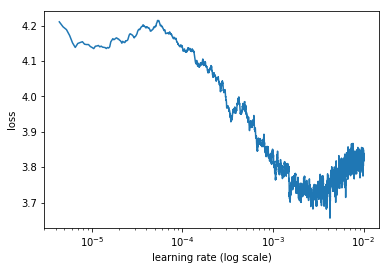

In [72]:
learner.sched.plot()

In [18]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 24/22813 [00:04<1:05:43,  5.78it/s, loss=4.05] 
epoch      trn_loss   val_loss                                    
    0      3.520859   3.3397    
    1      3.414239   3.256222                                    
    2      3.382679   3.214397                                    
    3      3.345103   3.186118                                    
    4      3.317803   3.164937                                    



[array([3.16494])]

In [21]:
learner.save('lm1')

In [22]:
learner.save_encoder('lm1_enc')

In [60]:
learner.metrics = [accuracy]

In [61]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.404849   3.230745   0.37766   
    1      3.3694     3.200477   0.381436                         
    2      3.333383   3.17563    0.38456                          
    3      3.305569   3.153905   0.387501                         
    4      3.268965   3.135937   0.389919                         



[array([3.13594]), 0.3899190162679386]

In [62]:
learner.save('lm1')
learner.save_encoder('lm1_enc')

In [31]:
import torch

m=learner.model

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})


re1 = re.compile(r'  +')
def clean_text(x, remove_html=True, other=True):
    if remove_html:
        x = re.sub(r'<code>[^>]*</code>', '', x)
        x = re.sub(r'<[^>]*>', '', x)
        x = re.sub(r'(.*\/).*', '', x)
    if other:
        x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '').replace('<unk>','u_n').replace(' @.@ ','.').replace(
            ' @-@ ','-').replace('\\', ' \\ ').replace('"',"'").replace('(', ' ( ').replace('[', '[ ').replace(
            '->', ' -> ').replace('<', '').replace('>', '').strip()
    return re1.sub(' ', html.unescape(x).strip())




def num_str(s):
    return [stoi[i] for i in s.split()]

def to_batch_tensor(s):
    return Variable(torch.Tensor(s)).cuda()


def sample_model(m, s, l=50):
    t = num_str(clean_text(s))
    t = to_batch_tensor(t)
    t = t.view(1, -1).long()
    m[0].bs = 1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = itos[n.data[0]]
        print(word, end=' ')
#         if word=='<eos>': break
        res,*_ = m(n[0].unsqueeze(0))

    m[0].bs = bs
    
    

In [32]:
sample_model(m, "xbos xfld 1 What is Logistic Regression xfld 1")

..., and the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : : xfld 1 you can use the following : 
 xbos xfld 

In [33]:
sample_model(m, "xbos xfld 1 How to sort a list of strings? xfld 1 ", 100)

..., and the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : the following : : xfld 1 you can use the following : 
 xbos xfld 1 i have a list of lists that are in the list . i want to create a list of lists that are in the list . i want to create a list of lists that are in the list . i want to create a list of lists , 